# ０　元ネタ：ここを参考に実装しました
 - アプリ開発：Jupyter上でDashを使えるjupyter_dash
  - https://qiita.com/OgawaHideyuki/items/725f4ffd93ffb0d30b6c

# １　必要なライブラリのインストール

In [ ]:
!pip install jupyter_dash dash-bootstrap-components

# ２　ライブラリのインポート

## Webアプリ関係

In [ ]:
from jupyter_dash import JupyterDash 
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import requests
import pandas as pd


# ３　検索Ｗｅｂアプリの実装



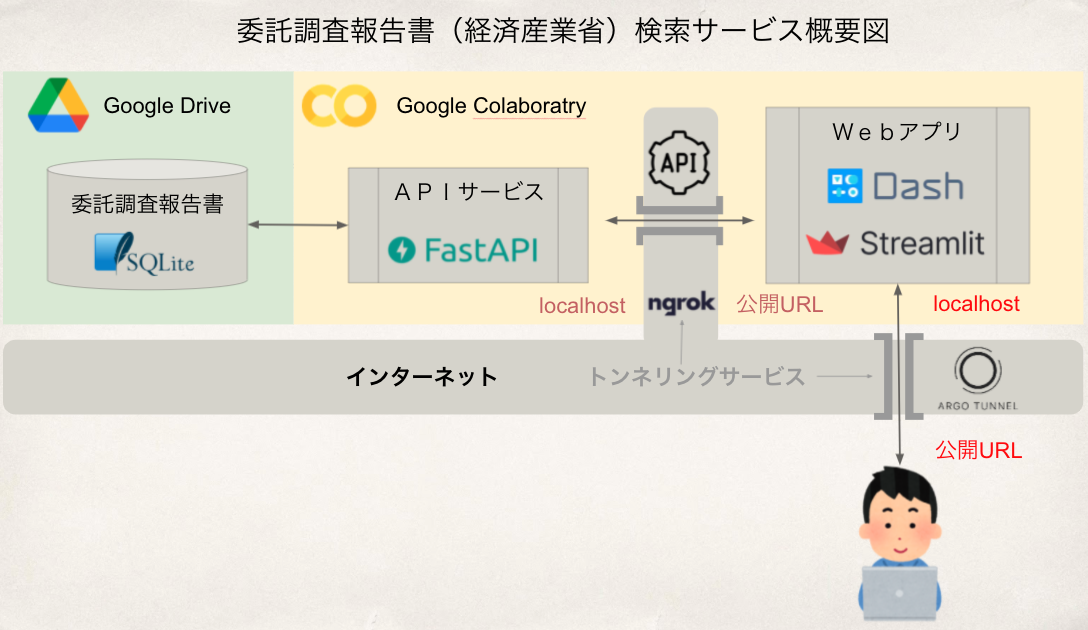

In [ ]:
API_URL = "http://dbfa962246f8.ngrok.io"

def get_report(key_word):
    if key_word == "":
        data = '[{"id":0, "report" : "キーワードを入れて下さい。"}]'
    elif "%" in key_word:
        data = '[{"id":0, "report" : "キーワードに「％」は使えません。"}]'
    else:
        query = '/api?key_word=' + key_word
        url = API_URL + query
        try:
            data = requests.get(url).json()
        except:
            data = '[{"id":0, "report" : "エラーが発生しました。"}]'
    if data == "[]":
        data = '[{"id":0, "report" : "該当する報告書はありません。"}]'
    df_out = pd.read_json(data)
    df_out = df_out[['id', 'report']]
    return df_out[::-1].head(20)

app = JupyterDash(__name__,
                # external_stylesheets=[dbc.themes.SUPERHERO],
                external_stylesheets=[dbc.themes.BOOTSTRAP],
                meta_tags=[{
                    'name': 'viewport',
                    'content': 'width=device-width, initial-scale=1.0'
                    }]
                )

# View
title = html.Div([
    dbc.Row([
        dbc.Col(
            dbc.Alert(html.H3("委託調査報告書の検索"), 
                      color="primary", style={'text-align':'center'}
                      )
        ),
    ], justify="center")
])

input_word = html.Div([
    dbc.Row([
        dbc.Col(
            html.H4('検索ワード：'), width="auto"
        ),
        dbc.Col(
            dcc.Input(
                id = 'id_word',
                placeholder='Press Enter to apply',
                type='text',
                value='',
                debounce=True,
                autoFocus=True,
            ), width="auto"
        ),
    ], no_gutters=True, justify="center")
])

output_table = html.Div([
    dbc.Row([
        dbc.Col(
            dash_table.DataTable(
                id='id_table',
                columns=[{"name": "id", "id": "id"},{"name": "report", "id": "report"}],
                style_cell={
                    'textAlign': 'left',
                    'overflow': 'hidden',
                    'textOverflow': 'ellipsis',
                    'maxWidth': 600,
                }
            ), width="auto"
        ),
    ], justify="center")
], style={'margin':'10px 0px 0px 0px'})

app.layout = dbc.Container([
                            title, 
                            input_word, 
                            output_table,
                            ])

# Controller
@app.callback(
	Output('id_table', 'data'),
	[Input('id_word', 'value')],
)
def search_report(word):
    df = get_report(word)
    return df.to_dict('records')

# ４　Ｗｅｂアプリをローカル環境で実行

In [ ]:
app.run_server(mode="inline")

# ５　Ｗｅｂアプリのデプロイ

## externalモードでWebアプリを起動

In [ ]:
app.run_server(mode='external', host="localhost", port=8050, debug=False)

## トンネリングで公開ＵＲＬを発行

In [ ]:
# cloudflaredのインストール　＆　localhostの8050ポートのトンネリングした公開URLを発行
!wget https://bin.equinox.io/c/VdrWdbjqyF/cloudflared-stable-linux-amd64.deb
!dpkg -i cloudflared-stable-linux-amd64.deb
!cloudflared tunnel --url localhost:8050